# Pixel Shuffle

This notebook is a comparison between two best practices. Pixel shuffle and upsampling followed by a convolution.

## Imports

In [0]:
from fastai import *
from fastai.tabular import *
import pandas as pd
from torchsummary import summary
import torch
from torch import nn
import imageio
import torch
import glob
from fastai.vision import *
import os
from torch import nn
import torch.nn.functional as F

## Data

In [2]:
colab = True
if colab:
  from google.colab import drive
  drive.mount('/content/drive', force_remount = True)
  %cp "/content/drive/My Drive/autoencoder-training/data.zip" .
  !unzip -q data.zip
  image_path = "data"
else: 
  os.chdir("../")
  image_path = os.getcwd() + "/data"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
np.random.seed(3333)
torch.manual_seed(3333)

size = 32
batchsize = 128

tfms = get_transforms(do_flip = True)
src = (ImageImageList.from_folder(image_path).split_by_folder().label_from_func(lambda x: x))
data = (src.transform(tfms, size=size, tfm_y=True)
        .databunch(bs=batchsize)
        .normalize(imagenet_stats, do_y = False))

## Model

In [0]:
class reshape(nn.Module):
  def __init__(self, shape):
      super(reshape, self).__init__()
      self.shape = shape
  def forward(self, x): return x.reshape(self.shape)

In [0]:
class AdaptiveConcatPool2d(Module):
    "Layer that concats `AdaptiveAvgPool2d` and `AdaptiveMaxPool2d`."
    def __init__(self, sz:Optional[int]=None):
        "Output will be 2*sz or 2 if sz is None"
        self.output_size = sz or 1
        self.ap = nn.AdaptiveAvgPool2d(self.output_size)
        self.mp = nn.AdaptiveMaxPool2d(self.output_size)

    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)

In [0]:
class Autoencoder(nn.Module):

    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.AdaptiveMaxPool2d(16),
            #nn.MaxPool2d(kernel_size = (2,2), stride = (2,2)),
            nn.BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.AdaptiveMaxPool2d(8),
            nn.BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(24 * 8 * 8, 1000)
        )

        self.decoder = nn.Sequential(
            nn.Linear(1000, 24 * 8 * 8),
            reshape([-1,24,8,8]),
            nn.Conv2d(24, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            PixelShuffle_ICNR(12, 12),
            nn.BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            PixelShuffle_ICNR(12, 3),
            nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
        )
        
    def encode(self,x): return self.encoder(x)
    
    def decode(self,x): return torch.clamp(self.decoder(x), min = 0, max=1)
        

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [0]:
ae = Autoencoder()
learn = Learner(data, ae, loss_func = F.mse_loss)

In [27]:
learn.summary()

Autoencoder
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [12, 32, 32]         324        True      
______________________________________________________________________
BatchNorm2d          [12, 32, 32]         24         True      
______________________________________________________________________
ReLU                 [12, 32, 32]         0          False     
______________________________________________________________________
Conv2d               [12, 32, 32]         1,296      True      
______________________________________________________________________
BatchNorm2d          [12, 32, 32]         24         True      
______________________________________________________________________
ReLU                 [12, 32, 32]         0          False     
______________________________________________________________________
AdaptiveMaxPool2d    [12, 16, 16]         0          False     
__________________________________________________

In [28]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,time
0,0.239805,0.221992,02:29
1,0.096991,0.096352,02:29
2,0.075897,0.076614,02:28
3,0.056253,0.058338,02:28
4,0.047171,0.047355,02:27
5,0.037660,0.038217,02:26
6,0.033209,0.034970,02:27
7,0.029180,0.030464,02:26
8,0.028139,0.029936,02:25
9,0.027969,0.029800,02:25


In [0]:
class convblock(nn.Module):
  def __init__(self, in_:int, out:int):
    super().__init__()
    self.conv1 = nn.Conv2d(in_, out, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    self.bn = nn.BatchNorm2d(out, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    self.relu = nn.ReLU(inplace=True)

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn(x)
    x = self.relu(x)
    return x

class downsamp(nn.Module):
  def __init__(self, size:int, scale:int=2):
    super().__init__()
    self.pool = nn.AdaptiveMaxPool2d(scale)
    self.bn = nn.BatchNorm2d(size, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    self.relu = nn.ReLU(inplace = True)

  def forward(self,x):
    x = self.pool(x)
    x = self.bn(x)
    x = self.relu(x)
    return x

In [0]:
class encoder1(nn.Module):
  def __init__(self):
    super(encoder1, self).__init__()
    self.convblock1 = convblock(3, 12)
    self.convblock2 = convblock(12,12)
    self.downsamp1 = downsamp(12, 16)

    self.convblock3 = convblock(12, 12)
    self.convblock4 = convblock(12,24)
    self.downsamp2 = downsamp(24, 8)

    self.bottleneck = nn.Sequential(nn.Flatten(),
                                    nn.Linear(24 * 8 * 8, 1000)
                                    )
  
  def forward(self, x):
    x = self.convblock1(x)
    x = self.convblock2(x)
    x = self.downsamp1(x)

    x = self.convblock3(x)
    x = self.convblock4(x)
    x = self.downsamp2(x)

    x = self.bottleneck(x)

    return x


class encoder2(nn.Module):
  def __init__(self):
    super(encoder2, self).__init__()
    self.convblock1 = convblock(3, 12)
    self.downsamp1 = downsamp(12, 16)

    self.convblock2 = convblock(12,24)
    self.downsamp2 = downsamp(24, 8)

    self.bottleneck = nn.Sequential(nn.Flatten(),
                                    nn.Linear(24 * 8 * 8, 1000)
                                    )
  
  def forward(self, x):
    x = self.convblock1(x)
    x = self.downsamp1(x)

    x = self.convblock2(x)
    x = self.downsamp2(x)

    x = self.bottleneck(x)

    return x

In [0]:
def icnr(x, scale=2, init=nn.init.kaiming_normal_):
    "ICNR init of `x`, with `scale` and `init` function."
    ni,nf,h,w = x.shape
    ni2 = int(ni/(scale**2))
    k = init(torch.zeros([ni2,nf,h,w])).transpose(0, 1)
    k = k.contiguous().view(ni2, nf, -1)
    k = k.repeat(1, 1, scale**2)
    k = k.contiguous().view([nf,ni,h,w]).transpose(0, 1)
    x.data.copy_(k)

class PixelShuffle_ICNR(nn.Module):
    "Upsample by `scale` from `ni` filters to `nf` (default `ni`), using `nn.PixelShuffle`, `icnr` init, and `weight_norm`."
    def __init__(self, ni:int, nf:int=None, scale:int=2, blur:bool=False, norm_type=NormType.Weight):
        super().__init__()
        nf = ifnone(nf, ni)
        self.conv = conv_layer(ni, nf*(scale**2), ks=1, norm_type=norm_type, use_activ=False)
        icnr(self.conv[0].weight)
        self.shuf = nn.PixelShuffle(scale)
        # Blurring over (h*w) kernel
        # "Super-Resolution using Convolutional Neural Networks without Any Checkerboard Artifacts"
        # - https://arxiv.org/abs/1806.02658
        self.pad = nn.ReplicationPad2d((1,0,1,0))
        self.blur = nn.AvgPool2d(2, stride=1)
        self.relu = nn.ReLU(inplace = True)

    def forward(self,x):
        x = self.shuf(self.relu(self.conv(x)))
        return self.blur(self.pad(x)) if self.blur else x

In [0]:
class Upsample1(nn.Module):
  def __init__(self, in_:int, out:int, scale:int=2, blur:bool=True):
    super().__init__()
    self.pixel_shuffle = PixelShuffle_ICNR(in_, out, scale, blur)
    self.bn = nn.BatchNorm2d(out, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    self.conv1 = nn.Sequential(
            nn.Conv2d(out, out, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(out, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
    )
    self.conv2 = nn.Sequential(
            nn.Conv2d(out, out, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(out, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
    )

  def forward(self, x):
    x = self.pixel_shuffle(x)
    x = self.bn(x)
    x = self.conv1(x)
    x = self.conv2(x)
    return x


class Upsample2(nn.Module):
  def __init__(self, in_:int, out:int, scale:int=2, blur:bool=True):
    super().__init__()
    self.pixel_shuffle = PixelShuffle_ICNR(in_, out, scale, blur)
    self.bn = nn.BatchNorm2d(out, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    self.conv1 = nn.Sequential(
            nn.Conv2d(out, out, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(out, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
    )

  def forward(self, x):
    x = self.pixel_shuffle(x)
    x = self.bn(x)
    x = self.conv1(x)
    return x

class Upsample3(nn.Module):
  def __init__(self, in_:int, out:int, scale:int=2, blur:bool=True):
    super().__init__()
    
    self.pixel_shuffle = PixelShuffle_ICNR(in_, out, scale, blur)
    self.bn = nn.BatchNorm2d(out, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

  def forward(self, x):
    x = self.pixel_shuffle(x)
    x = self.bn(x)
    return x

In [0]:
class decoder1(nn.Module):
  def __init__(self):
    super(decoder1, self).__init__()

    self.bottleneck = nn.Sequential(nn.Linear(1000, 24 * 8 * 8),
                                    reshape([-1,24,8,8]))
    self.up1 = Upsample1(24, 12)
    self.up2 = Upsample1(12,3)

  def forward(self, x):
    x = self.bottleneck(x)
    x = self.up1(x)
    x = self.up2(x)
    return x


class decoder2(nn.Module):
  def __init__(self):
    super(decoder2, self).__init__()

    self.bottleneck = nn.Sequential(nn.Linear(1000, 24 * 8 * 8),
                                    reshape([-1,24,8,8])
    )
    self.up1 = Upsample2(24, 12)
    self.up2 = Upsample2(12,3)

  def forward(self, x):
    x = self.bottleneck(x)
    x = self.up1(x)
    x = self.up2(x)
    return x

class decoder3(nn.Module):
  def __init__(self):
    super(decoder3, self).__init__()

    self.bottleneck = nn.Sequential(nn.Linear(1000, 24 * 8 * 8),
                                    reshape([-1,24,8,8])
    )
    self.up1 = Upsample3(24, 12)
    self.up2 = Upsample3(12,3)

  def forward(self, x):
     x = self.bottleneck(x)
     x = self.up1(x)
     x = self.up2(x)
     return x


In [0]:
class autoencoder1(nn.Module):
  def __init__(self):
    super(autoencoder1, self).__init__()

    self.encoder = encoder1()
    self.decoder = decoder1()

  def encode(self, x): return self.encoder(x)
  def decode(self, x): return torch.clamp(self.decoder(x), min = 0, max = 1)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return torch.clamp(x, min = 0, max = 1)

class autoencoder2(nn.Module):
  def __init__(self):
    super(autoencoder2, self).__init__()

    self.encoder = encoder2()
    self.decoder = decoder2()

  def encode(self, x): return self.encoder(x)
  def decode(self, x): return torch.clamp(self.decoder(x), min = 0, max = 1)
  
  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return torch.clamp(x, min = 0, max = 1)

class autoencoder3(nn.Module):
  def __init__(self):
    super(autoencoder3, self).__init__()

    self.encoder = encoder2()
    self.decoder = decoder3()

  def encode(self, x): return self.encoder(x)
  def decode(self, x): return torch.clamp(self.decoder(x), min = 0, max = 1)
  
  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return torch.clamp(x, min = 0, max = 1)

In [0]:
ae1 = autoencoder1()
ae2 = autoencoder2()
ae3 = autoencoder3()

In [0]:
learn1 = Learner(data, ae1, loss_func = F.mse_loss)

In [94]:
learn1.fit_one_cycle(5)

epoch,train_loss,valid_loss,time
0,0.021753,0.026993,02:33
1,0.012498,0.014329,02:33
2,0.010294,0.012828,02:33
3,0.009305,0.010807,02:32
4,0.008804,0.010425,02:29


In [0]:
learn2 = Learner(data, ae2, loss_func = F.mse_loss)

In [96]:
learn2.fit_one_cycle(5)

epoch,train_loss,valid_loss,time
0,0.016810,0.015733,02:29
1,0.007504,0.008763,02:30
2,0.005823,0.007173,02:30
3,0.005152,0.006515,02:30
4,0.004784,0.006251,02:30


In [0]:
learn3 = Learner(data, ae3, loss_func = F.mse_loss)

In [117]:
learn3.fit_one_cycle(5)

epoch,train_loss,valid_loss,time
0,0.036024,0.029593,02:29
1,0.007139,0.008784,02:29
2,0.005153,0.006952,02:30
3,0.004308,0.005748,02:29
4,0.003999,0.005497,02:30


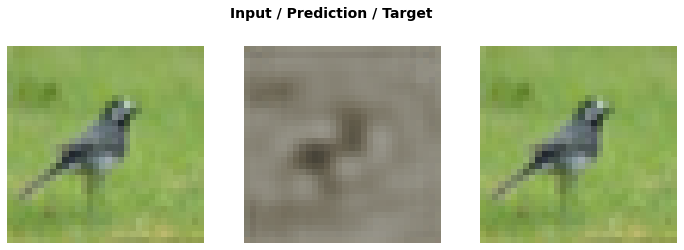

In [99]:
learn1.show_results(rows = 1)

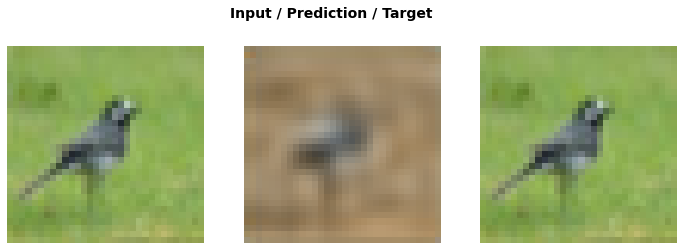

In [100]:
learn2.show_results(rows = 1)

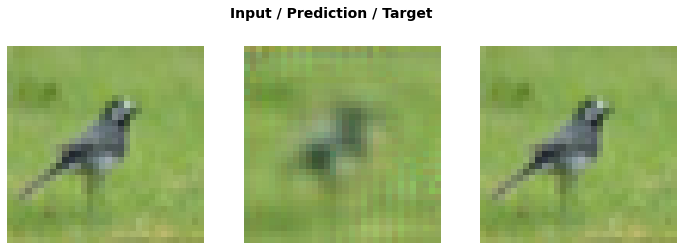

In [118]:
learn3.show_results(rows = 1)

In [0]:
test_tens = torch.rand([32,3,32,32])

In [0]:
encoded = ae1.encode(test_tens.cuda())

In [0]:
enc1 = encoder1()

In [0]:
encoded = enc1(test_tens)

In [88]:
encoded.shape

torch.Size([32, 1000])

In [0]:
dec1 = decoder1()

In [0]:
decoded = dec1(encoded)

In [91]:
decoded.shape

torch.Size([32, 3, 32, 32])

In [47]:
encoded.shape

AttributeError: ignored

In [54]:
ae1(test_tens.cuda())

NotImplementedError: ignored